# Combined leaf and wood Xylariaceae analysis

We will use our combined biom table of leaf and wood endophytes to ask some questions about the roles of both leaf- and sapwood-inhabiting endophytes on nearby stromata, focusing on the family Xylariaceae.

<a id='contents'></a>

## Contents

[Importing biom table and setup](#import)  
[Negative control cleanup](#nc)  
[Variance Stabilization of Read Counts](#deseq)  
[Redundancy Analysis](#rda)

<a id='import'></a>

## Importing biom table and setup

Let's get the proper packages and import our biom table.

In [2]:
library('phyloseq')
library('DESeq2')
library('repr')

Import our biom table. We used the green genes style of formatting for our taxonomy metadata, I think...

In [3]:
biom95 <- import_biom('combo_95_wMeta.biom', parseFunction=parse_taxonomy_greengenes)

Our biom table:

In [4]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10269 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10269 taxa by 7 taxonomic ranks ]

Here is our current metadata for samples. We can subset by library type (leaf or wood), sample or control, and sample number. The unique identifiers (first column) were the name of the sample assigned by the illumina software.

In [5]:
head(sample_data(biom95))

,SampleNumber,SorC,Library
160wood,Dc-X,Control,W
161wood,Dc-PosG,Control,W
162wood,Dc-PosI,Control,W
163wood,Dc-Neg,Control,W
164wood,1,Sample,W
165wood,2,Sample,W


<a id='nc'></a>

## Cleanup of biom tables using negative controls

Okay, as per the recommendations of [Nguyen 2015](http://onlinelibrary.wiley.com/doi/10.1111/nph.12923/full), we'll remove sequences of OTUs found in our negative controls, up to the amount of reads found for these OTUs in our negative controls. 

What do we find in our negatives? Make a phyloseq object of just our wood negative:

In [6]:
neg95 <- subset_samples(biom95, SampleNumber=='Neg')

In [7]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10269 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10269 taxa by 7 taxonomic ranks ]

How many contaminants do we have? Total reads:

In [8]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1757

Which OTUs, and how many of each?

In [9]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU66:65Leaf     OTU39:65Leaf  OTU1732:163wood OTU199:112.2Leaf 
             543               98                1               40 
  OTU623:114Leaf   OTU206:161wood   OTU695:164wood   OTU237:161wood 
              61                1               69              109 
    OTU77:12Leaf   OTU132:104Leaf    OTU89:161wood   OTU185:161wood 
               1               56                3                2 
  OTU161:161wood   OTU106:122Leaf    OTU181:70Leaf   OTU256:161wood 
               1                2                1              108 
  OTU198:161wood   OTU444:161wood   OTU782:192wood     OTU47:51Leaf 
               1               51                1                1 
  OTU291:167wood   OTU313:164wood   OTU343:164wood   OTU234:165wood 
               1               20                1                1 
    OTU16:14Leaf   OTU308:173wood    OTU204:35Leaf     OTU18:55Leaf 
               1                1                1                1 
   OTU19:100Leaf   OTU521:132Leaf  OTU1193:103Leaf  OTU1436:172wood 
               1                1               36               64 
  OTU240:167wood    OTU167:90Leaf  OTU1283:170wood  OTU2363:168wood 
             185                1                4                4 
  OTU747:254wood    OTU63:194wood   OTU2828:34Leaf  OTU1444:255wood 
               1               13                1               50 
 OTU1066:125Leaf   OTU806:121Leaf  OTU1103:172wood  OTU1768:252wood 
               1               60               48                1 
 OTU1337:240wood   OTU5161:51Leaf  OTU8871:173wood    OTU727:48Leaf 
              32               23                1                1 
  OTU471:190wood  OTU1554:183wood  OTU1189:199wood    OTU30:207wood 
               1                1               44                3 
  OTU766:252wood  OTU1781:253wood 
               1                2

A quick visual summary of the top 15 contaminants:

In [10]:
aa <- taxa_sums(neg95)[taxa_sums(neg95)>0]
aa <- sort(aa, decreasing = TRUE)[1:15]
neg95_top15 <- prune_taxa(names(aa), neg95)

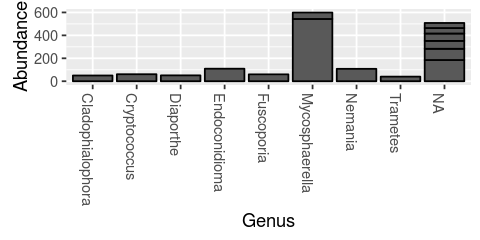

In [11]:
options(repr.plot.width = 4, repr.plot.height = 2) ## using repr to control size of R plotter outputs
plot_bar(neg95_top15, "Genus")

This stacks OTUs in the same taxonomic category into a single column. Hence, two OTUs assigned to *Mycosphaerella* are stacked, and 6 unidentified OTUs are stacked into the final bin. 

So, we can subtract the sequence quantities found in our negative control from all other samples by digging into the architecture of our phyloseq objects. If we look at our biom95 object, we can see that our read counts are stored in a matrix-like object in the otu_table slot:

In [12]:
str(biom95)

Formal class 'phyloseq' [package "phyloseq"] with 5 slots
  ..@ otu_table:Formal class 'otu_table' [package "phyloseq"] with 2 slots
  .. .. ..@ .Data        : num [1:10269, 1:232] 70749 4 2 316 8 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:10269] "OTU17:114Leaf" "OTU7811:160wood" "OTU2412:53Leaf" "OTU494:114Leaf" ...
  .. .. .. .. ..$ : chr [1:232] "160wood" "161wood" "162wood" "163wood" ...
  .. .. ..@ taxa_are_rows: logi TRUE
  ..@ tax_table:Formal class 'taxonomyTable' [package "phyloseq"] with 1 slot
  .. .. ..@ .Data: chr [1:10269, 1:7] "Fungi" "Fungi" "Fungi" "Fungi" ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:10269] "OTU17:114Leaf" "OTU7811:160wood" "OTU2412:53Leaf" "OTU494:114Leaf" ...
  .. .. .. .. ..$ : chr [1:7] "Kingdom" "Phylum" "Class" "Order" ...
  ..@ sam_data :'data.frame':	232 obs. of  3 variables:
Formal class 'sample_data' [package "phyloseq"] with 4 slots
  .. .. ..@ .Data    :List of 3
  .. .. .. ..$

To subtract the negative control reads from the others, we can treat these objects like matrices and subtract the column of the negative control from all other columns. In this case, we need to subtract the wood column negative control from the wood samples, and the leaf negative controls from the leaves (there are two). 

In [22]:
## make a phyloseq object, in case we mess something up:
biom95.nonc <- biom95

Wood samples:

In [14]:
wood95 <- subset_samples(biom95, Library=='W') ## our wood samples
woodneg95 <- subset_samples(biom95, SampleNumber=='Neg') ## our wood negative
wood95@otu_table@.Data <- wood95@otu_table@.Data - woodneg95@otu_table@.Data[,1] ## subtract out the controls

Leaf samples:

In [17]:
leaf95 <- subset_samples(biom95, Library=='L')  ## leaves only
leafneg95 <- subset_samples(biom95, SampleNumber=='NC_1' | SampleNumber=='NC_2') ## leaf negative controls
leaf95@otu_table@.Data <- leaf95@otu_table@.Data - leafneg95@otu_table@.Data[,1] - leafneg95@otu_table@.Data[,2] ## subtract out the controls

Now reassemble these, plus the stromata abundance column. Negative numbers are reassigned a zero value:

In [18]:
strom95 <- subset_samples(biom95, Library=='S')  ## stromata
bb <- cbind(wood95@otu_table@.Data, leaf95@otu_table@.Data, strom95@otu_table@.Data)
bb[bb < 0] <- 0

Before we do the deed, make sure that dimensions, row/column order have been preserved:

In [19]:
any(colnames(biom95@otu_table@.Data) != colnames(bb))
any(rownames(biom95@otu_table@.Data) != rownames(bb))

[1] FALSE

[1] FALSE

In [20]:
dim(bb)
dim(biom95@otu_table@.Data)

[1] 10269   232

[1] 10269   232

Same row and column names/order, same dimensions, looks good. Substituting this new species matrix into our new phyloseq object:

In [23]:
biom95.nonc@otu_table@.Data <- bb

<a id='deseq'></a>

## Variance stabilization of our reads

It's important to [stabilize the variance](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531of) of our combined-leaf-and-wood-endophyte read depths, we'll do this using the [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) package in R. This is a way of making the samples, which have highly variable numbers of reads in them, comparable for downstream statistical analyses.

For the moment, we will repeat Roo's pipeline that he used to lay the groundwork for his other analyses with the leaf-only data. We want to treat this new data as similarly as possible. His first step was to remove controls and low-read (<2000) samples. 

How many samples have less than 2000 reads in our biom table?

In [24]:
sample_sums(biom95.nonc)[sample_sums(biom95.nonc) < 2000]

255wood  NC_2Leaf    86Leaf  NC_1Leaf    18Leaf    67Leaf 112_1Leaf 113_2Leaf 
        0         0       554         0      1400      1340         1         3 
   74Leaf 113_1Leaf 126_2Leaf    91Leaf     Strom 
      286        45         2         6        51

Not many. Some of these needed to be removed anyway, the negative controls and the low-read "\_" reads, which represented empty samples included in the run. 

In [26]:
biom95_hiread <- prune_samples(sample_sums(biom95.nonc)>=2000, biom95)

Did this work? 

In [27]:
sample_sums(biom95_hiread)[sample_sums(biom95_hiread) < 2000]

named numeric(0)

Nada. Worked. Now remove controls. We'll work more with the mock communities and other positive controls in the future. The leaves did not contain a positive control, so this is out of the scope of Roo's analysis. 

In [28]:
biom95_hiread_nocontrol <- subset_samples(biom95_hiread, SorC=="Sample")

In [29]:
head(sample_data(biom95_hiread_nocontrol)); tail(sample_data(biom95_hiread_nocontrol))

,SampleNumber,SorC,Library
164wood,1,Sample,W
165wood,2,Sample,W
166wood,3,Sample,W
167wood,4,Sample,W
168wood,5,Sample,W
169wood,7,Sample,W


,SampleNumber,SorC,Library
47Leaf,47,Sample,L
39Leaf,39,Sample,L
5Leaf,5,Sample,L
28Leaf,28,Sample,L
19Leaf,19,Sample,L
3Leaf,3,Sample,L


Roo has written a function to stream-line the process of using deseq variance stabilization, because it was originally written for RNA-seq data, with dense matrices. Species matrices are usually pretty sparse, so deseq needs a few workarounds to handle our kind of data. Thankfully, Roo has worked on this, and saved me probably weeks of work. His function looks like this: 


In [30]:
DESeq_varstab <- function(phyloseq, design) {
# phyloseq = the input phyloseq object that you want to get DESeq transformed counts for
# design_variable = the design for the conversion to the DESeq object. must be in the form "as a function of", for example "~Host_Genus", must be a variable in the phyloseq object

        # Set variables to NULL
        deseq.vst = NULL
        geo_Means = NULL
        phyloseq.DESeq = NULL

        # Convert to a DESeq object
        deseq = phyloseq_to_deseq2(phyloseq, design)

        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
                exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
                }

        geo_Means = apply(counts(deseq), 1, gm_mean)

        # Check to see if any columns (samples) don't have any OTUs in them:
        if(sum(colSums(counts(deseq)) == 0) == 0) { # if all samples have taxa, go on

                # Now we step through the size factors, dispersions, and varience stabilization:
                deseq = estimateSizeFactors(deseq, geoMeans = geo_Means)
                deseq = estimateDispersions(deseq) # long step
                deseq.vst = getVarianceStabilizedData(deseq)

                # replace negatives with zeros
                deseq.vst[deseq.vst <0] <- 0

                # add the varience stabilized otu numbers into the dataset:
                otu_table(phyloseq) <- otu_table(deseq.vst, taxa_are_rows = TRUE)

                # create a new object for the varience stabalized set
                phyloseq -> phyloseq.DESeq

                # And, filter any taxa that became 0s all the way across
                phyloseq.DESeq = filter_taxa(phyloseq.DESeq, function(x) sum(x) > 0.1, T)

                # return the new phyloseq object
                return(phyloseq.DESeq)

        } # end of IF loop 
        else {return("Error: your phyloseq object has samples with no taxa present.")}

} # end function


So let's try it out on our data. DESeq asks for an experimental design to incorporate in its modeling of read counts. In this instance, we are making comparisons of the relative importance of the origins of our endophytes - are wood endophytes or leaf endophytes more predictive of decomposers (stromata) at a given site? With this question, I believe the design variable is the origin of the sample, leaf or wood, (our "Library" metadata variable). 

In [31]:
## match Roo's random seed set, not sure if this is necessary for DeSeq but let's err on the side of caution
set.seed(28132)

In [35]:
deseq95 <- DESeq_varstab(biom95_hiread_nocontrol, ~Library)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Roo's function goes into DESeq land and back, returning us a phyloseq object. How does our data look after touching the void and coming back to us?

In [36]:
deseq95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7029 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 7029 taxa by 7 taxonomic ranks ]

In [37]:
biom95_hiread_nocontrol

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10269 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 10269 taxa by 7 taxonomic ranks ]

Looks like we lost some taxa. Let's compare the distributions of our read depths before and after variance stabilization:

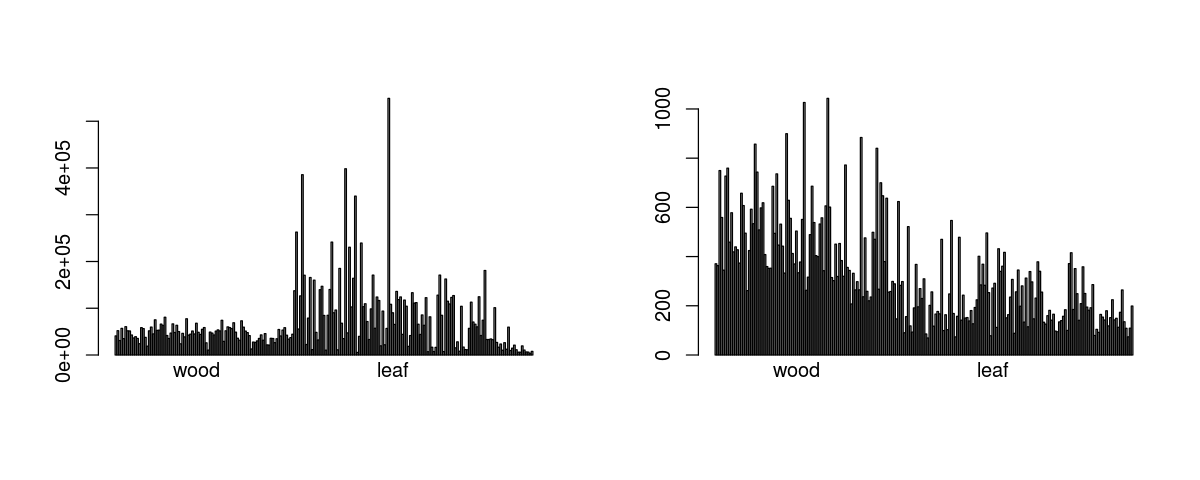

In [47]:
par(mfrow = c(1,2))
options(repr.plot.width = 10, repr.plot.height = 4)

barplot(sample_sums(biom95_hiread_nocontrol), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

barplot(sample_sums(deseq95), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

Huh, it looks like the wood retained more reads than the leaves. I'm a bit confused by this and our low read numbers in general after variance stabilization. Maybe this is due to the very different abundances present between the two studies.  

<a id='rda'></a>

# Redundancy analysis (RDA) 

To examine the relative importances of leaf and wood endophytes in predicting decomposer (stromata) populations, we'll use a redundancy analysis. This is a constrained, direct-gradient type of analysis that is kind of like a multiple regression of a response (Y) matrix to several explanatory (X) matrices. There is a [good explanation](https://sites.google.com/site/mb3gustame/constrained-analyses/rda) of RDA methods in my favorite statistical website, [GUSTA ME](https://sites.google.com/site/mb3gustame/home).

One of the nice things about RDA is that it is constrained, meaning that it focuses on the variation in our response matrix that can be explained by the variables we supply, though there is some estimation of unexplained variation. We do not expect that all or even most of the variation in our decomposer matrix will be explained by either the leaf or wood endophyte populations. Much of the variation is probably due to environmental conditions, etc. But here we check to see if any variation in our decomposers can be predicted by endophytes, and if so, the relative importance of our leaf and wood endophytes. 

### Formatting inputs for RDA

For our RDA, we'll need three matrices. Our "y" matrix will be the observations of stromata from our sites. The "x" matrices will be our wood and leaf species matrices. All three will need to be of the same sites, meaning we need to trim down to the smallest matrix. This is our wood matrix, which had successful DNA purification and amplification in only 91 samples.

**Wood matrix**

To get our wood samples which contained Xylariaceae:

In [129]:
wood95 <- subset_samples(deseq95, Library=='W') ## wood samples only
Xwood95 <- subset_taxa(wood95, Family=='Xylariaceae') ## subset to Xyalriaceae
Xwoodmat <- t(otu_table(Xwood95)@.Data) ## get our species matrix out
Xwoodmat <- Xwoodmat[,colSums(Xwoodmat) > 0] ## get rid of empty columns

Looks like this:

In [130]:
Xwoodmat[1:10,1:5]

,OTU17:114Leaf,OTU206:161wood,OTU256:161wood,OTU189:90Leaf,OTU734:75Leaf
164wood,0.000000,0.0000000,0,0,0
165wood,1.499134,0.0000000,0,0,0
166wood,0.000000,0.0000000,0,0,0
167wood,0.000000,0.0000000,0,0,0
168wood,0.000000,0.0000000,0,0,0
169wood,0.000000,0.0000000,0,0,0
170wood,0.000000,0.0000000,0,0,0
171wood,0.000000,0.4860454,0,0,0
172wood,0.000000,1.1380200,0,0,0
173wood,2.898913,0.7212740,0,0,0


Nice, but let's rename our rows by their actual sample number, not the names that the illumina software gave them.

In [131]:
Xwoodnames <- sample_data(Xwood95)@.Data[[1]]
rownames(Xwoodmat) <- Xwoodnames
Xwoodmat[1:10,1:5]

,OTU17:114Leaf,OTU206:161wood,OTU256:161wood,OTU189:90Leaf,OTU734:75Leaf
1,0.000000,0.0000000,0,0,0
2,1.499134,0.0000000,0,0,0
3,0.000000,0.0000000,0,0,0
4,0.000000,0.0000000,0,0,0
5,0.000000,0.0000000,0,0,0
7,0.000000,0.0000000,0,0,0
9,0.000000,0.0000000,0,0,0
10,0.000000,0.4860454,0,0,0
11,0.000000,1.1380200,0,0,0
13,2.898913,0.7212740,0,0,0


Notice that some rows are missing, where sampling was unsucessful. We need to create a leaf matrix and trim to these samples, since we can only compare among the three matrices where all were sampled.

**Leaf matrix**

Get the matrix as with the wood above:

In [132]:
leaf95 <- subset_samples(deseq95, Library=='L')  ## leaves only
Xleaf95 <- subset_taxa(leaf95, Family=='Xylariaceae')
Xleafmat <- t(otu_table(Xleaf95)@.Data) ## leaf species matrix
Xleafmat <- Xleafmat[,colSums(Xleafmat) > 0] ## get rid of empty columns
Xleafnames <- sample_data(Xleaf95)@.Data[[1]] ## get sample numbers
## get rid of "_" character in two of our sample names:
Xleafnames[10] <- "112"
Xleafnames[92] <- "126"
rownames(Xleafmat) <- leafnames
Xleafmat[1:10,1:5]

,OTU17:114Leaf,OTU256:161wood,OTU189:90Leaf,OTU734:75Leaf,OTU2498:87Leaf
100,4.515438,0,0.000000,0.0000000,0
78,0.000000,0,0.000000,2.3942426,0
97,4.966791,0,1.240601,4.1004346,0
90,0.000000,0,1.615465,0.8816081,0
27,1.844523,0,0.000000,0.0000000,0
21,0.000000,0,0.000000,0.0000000,0
88,0.000000,0,0.000000,0.0000000,0
104,8.946683,0,0.000000,0.0000000,0
81,0.000000,0,0.000000,0.0000000,0
112,0.000000,0,0.000000,0.6102818,0


In all the processing, the sample order was totally lost in the leaf reads. Fix this:

In [142]:
bb <- sort(as.numeric(rownames(Xleafmat))) ## create a vector of sorted row names
cc <- as.character(bb) ##turn them back into characters
Xleafmat <- Xleafmat[cc,] ## use them to sort our matrix
Xleafmat[1:10,1:3] ## take a look

,OTU17:114Leaf,OTU256:161wood,OTU189:90Leaf
1,0.0000000,0,0
2,0.0000000,0,0
3,0.0000000,0,0
4,0.0000000,0,0
5,0.0000000,0,0
6,0.0000000,0,0
7,0.0000000,0,0
8,0.0000000,0,0
9,0.0000000,0,0
12,0.7666616,0,0


**Stromata matrix**

The stromata data are in a csv, compiled by Roo:

In [143]:
stromata <- as.matrix(read.csv(file='stromata.csv'))
## our rownames were imported as the first column of the matrix, fix this:
rownames(stromata) <- stromata[,1] 
stromata <- stromata[,-1] ## drop this original first row of names

In [144]:
stromata[1:10,1:5]

,A_aff_atroroseum,A_aff_stygium,A_atroroseum,A_bovei_var_microspora,A_moriforme
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0
10,0,0,0,0,0


Notice, no gaps in the sample numbers in this matrix. We completed sampling for stromata at all plots, so this matrix has the most samples.

In [145]:
dim(stromata)

[1] 133  52

**Pruning matrices** 

We can only make statements about samples where all three matrices have data. Right now, each of our matrices has a slightly different set of samples included within it, resulting in different numbers of rows:

In [146]:
dim(Xwoodmat)
dim(Xleafmat)
dim(stromata)

[1] 91 94

[1] 122 182

[1] 133  52

So we need to prune all matrices down to only the rows (samples) that all three matrices contain. First, we prune our wood and leaf matrices to each other:

In [155]:
Xwoodmat <- Xwoodmat[rownames(Xwoodmat) %in% rownames(Xleafmat), ]
Xleafmat <- Xleafmat[rownames(Xleafmat) %in% rownames(Xwoodmat), ]

Our stromata matrix also needs to be pruned to match our wood/leaves:

In [156]:
stromata <- stromata[rownames(stromata) %in% rownames(Xleafmat), ]

Do they all have the same number of rows? Are these row numbers identical?

In [157]:
dim(Xwoodmat)
dim(Xleafmat)
dim(stromata)

[1] 83 94

[1]  83 182

[1] 83 52

In [158]:
dim(woodmat); dim(leafmat); dim(stromata) 

[1]   83 7029

[1]   83 7029

[1] 83 52

In [159]:
any(rownames(woodmat) != rownames(leafmat)); any(rownames(woodmat) != rownames(stromata))

[1] FALSE

[1] FALSE

**Convert to Presence/Absence data**

Doing to this because I do not trust our read abundances or stromata counts to be ecologically meaningful. See notes [here](#mockcom).

In [160]:
Xwoodmat[Xwoodmat > 0] <- 1
Xleafmat[Xleafmat > 0] <- 1
stromata[stromata > 0] <- 1